In [1]:
%pip install tfds

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 0.1 Requires-Python >=3.11,<3.13; 0.2 Requires-Python >=3.11,<3.13; 0.3 Requires-Python >=3.11,<3.13
ERROR: Could not find a version that satisfies the requirement tfds (from versions: none)
ERROR: No matching distribution found for tfds


# Imports

In [1]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# Dataset

- http://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_200.zip
- http://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_400.zip
- http://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip

In [ ]:

zip_file = "Data_sheep_cat_elephant_with_caption_600.zip"

# Charger les images d'un dossier
data_dir = "./data/dataset/sheep_cat_elephant_with_caption_600/"

os.makedirs('./data/dataset/', exist_ok=True)


#!wget https://www.lirmm.fr/~poncelet/Ressources/cnn_models.zip
!Powershell.exe -Command ((new-object System.Net.WebClient).DownloadFile('https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip','Data_sheep_cat_elephant_with_caption_600.zip'))

# Extraction du fichier ZIP
with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)

# Suppression du fichier ZIP après extraction pour économiser de l'espace
os.remove(zip_file)

In [2]:
batch_size = 32
img_height = 256
img_width = 256



# Charger les images d'un dossier
data_dir = "./data/dataset/sheep_cat_elephant_with_caption_600/images/"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 1800 files belonging to 3 classes.
Using 1440 files for training.
Found 1800 files belonging to 3 classes.
Using 360 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)


['cat', 'elephant', 'sheep']


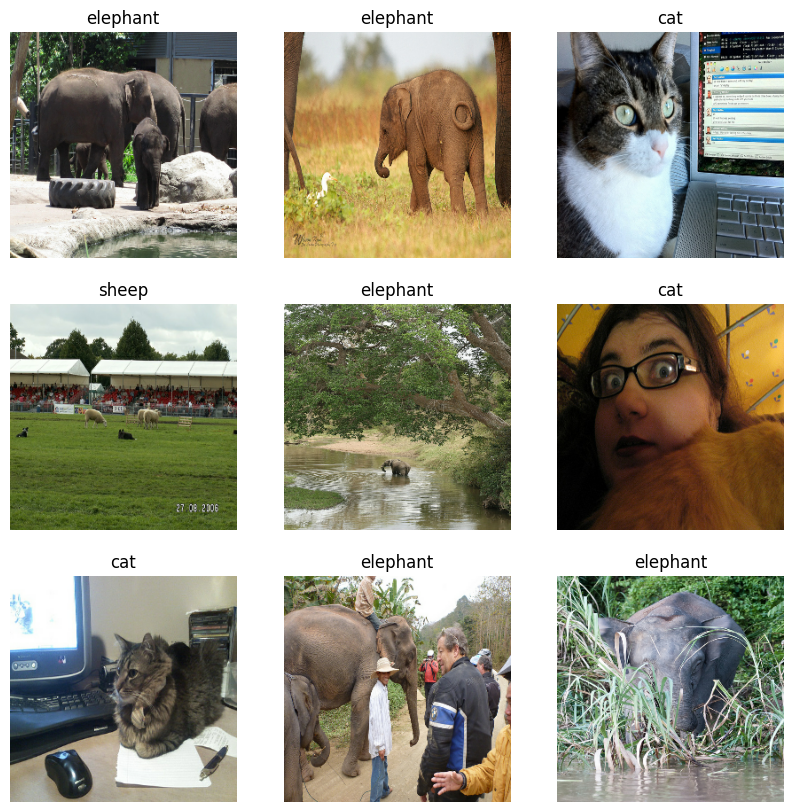

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [3]:
def define_model(shapeinput=(256, 256, 3)):
    # Définir l'entrée
    inputs = Input(shape=shapeinput, name="Input_Layer")

    # conv
    x = Conv2D(32, (3, 3), activation='relu', name="Conv1_Layer")(inputs)
    x = MaxPooling2D((2, 2), name="Pool1_Layer")(x)
    x = Conv2D(32, (5, 5), activation='relu', name="Conv2_Layer")(x)
    x = MaxPooling2D((2, 2), name="Pool2_Layer")(x)
    x = Conv2D(32, (5, 5), activation='relu', name="Conv3_Layer")(x)
    x = MaxPooling2D((2, 2), name="Pool3_Layer")(x)
    x = Flatten(name="Flatten_Layer")(x)

    # Partie classification
    x = Dense(200, activation='relu', name="Dense1_Layer")(x)
    outputs = Dense(3, activation='softmax', name="Output_Layer")(x)

    # Construction du modèle
    model = Model(inputs=inputs, outputs=outputs)

    # Compilation
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [5]:
def evaluate_model(model, dataX, dataY, folds=5, epochs=10):
    """
    Évalue le modèle avec une validation croisée K-fold.

    Paramètres :
    - model : modèle de réseau de neurones Keras à évaluer.
    - dataX : données d'entrée pour l'entraînement et la validation.
    - dataY : étiquettes de sortie correspondantes.
    - folds : nombre de splits pour la validation croisée.
    - epochs : nombre d'époques pour l'entraînement de chaque split.

    Retourne :
    - scores : liste des scores d'accuracy du modèle pour chaque split.
    - histories : liste des historique d'entraînement pour chaque split.
    """
    scores, histories = [], []  # Initialisation des scores et historiques
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)

    # Itération sur chaque split généré par le K-fold
    for train_ix, test_ix in kfold.split(dataX):
        # Sélection des données d'entraînement et de test pour le fold
        X_train, y_train = dataX[train_ix], dataY[train_ix]
        X_test, y_test = dataX[test_ix], dataY[test_ix]

        # Réinitialisation du modèle avant chaque itération
        model = define_model()


        # Entraînement du modèle
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32,
                            validation_data=(X_test, y_test), verbose=1)

        # Évaluation du modèle sur les données de test actuelles
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Précision : {acc * 100:.3f}%')

        # Stockage de l'historique
        scores.append(acc)
        histories.append(history)

    return scores, histories

In [6]:
def load_dataset():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=124,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        seed=124,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    X_train_list, y_train_list = [], []
    for x, y in train_ds:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())

    X_test_list, y_test_list = [], []
    for x, y in val_ds:
        X_test_list.append(x.numpy())
        y_test_list.append(y.numpy())

    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    # One-hot
    numClass = len(train_ds.class_names)
    y_train = to_categorical(y_train, num_classes=numClass)
    y_test = to_categorical(y_test, num_classes=numClass)

    return X_train, y_train, X_test, y_test, train_ds.class_names

In [7]:
def clean_data(train, test):
    """
    Prétraitement des données : conversion en float, normalisation entre 0 et 1.

    Paramètres :
    - train : tableau de données d'entraînement
    - test : tableau de données de test

    Retourne :
    - train_norm : données d'entraînement normalisées
    - test_norm : données de test normalisées
    """
    # Conversion des entiers en floats pour permettre la normalisation
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    # Normalisation des valeurs entre 0 et 1
    train_norm /= 255.0
    test_norm /= 255.0

    return train_norm, test_norm

In [8]:
def plot_curves(histories):
    """
    Fonction pour afficher les courbes de loss et d'accuracy
    moyennées et écart-types à travers les k-folds.

    Paramètres :
    - histories (list) : Historique d'entraînement des différents plis K-folds.
    """

    # Initialisation des figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Extraction du nombre d'époques d'après l'un des historiques
    epochs = range(len(histories[0].history['loss']))

    # Calcul des moyennes et des écart-types pour chaque époque
    mean_loss = np.mean([history.history['loss'] for history in histories],
                        axis=0)
    std_loss = np.std([history.history['loss'] for history in histories],
                      axis=0)

    mean_val_loss = np.mean([history.history['val_loss'] for history in histories],
                            axis=0)
    std_val_loss = np.std([history.history['val_loss'] for history in histories],
                          axis=0)

    mean_accuracy = np.mean([history.history['accuracy'] for history in histories],
                            axis=0)
    std_accuracy = np.std([history.history['accuracy'] for history in histories],
                          axis=0)

    mean_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories],
                                axis=0)
    std_val_accuracy = np.std([history.history['val_accuracy'] for history in histories],
                              axis=0)

    # Couleurs pour les courbes
    train_color = 'blue'
    val_color = 'orange'

    # Courbes de loss avec moyenne et écart-type
    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss,
                     color=train_color, alpha=0.2)

    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, color=val_color, alpha=0.2)

    # Courbes d'accuracy avec moyenne et écart-type
    ax2.plot(epochs, mean_accuracy, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_accuracy - std_accuracy,
                     mean_accuracy + std_accuracy, color=train_color, alpha=0.2)

    ax2.plot(epochs, mean_val_accuracy, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_accuracy - std_val_accuracy,
                     mean_val_accuracy + std_val_accuracy,
                     color=val_color, alpha=0.2)

    # Titres, labels et légendes
    ax1.set_title(f'Loss (k={len(histories)})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title(f'Accuracy (k={len(histories)})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [9]:
def run_evaluation(folds, epochs):
    """
    Fonction d'évaluation

    Cette fonction effectue les étapes suivantes :
    1. Chargement du jeu de données Fashion MNIST.
    2. Prétraitement des données : nettoyage et normalisation.
    3. Initialisation du modèle de base et affichage de sa structure.
    4. Évaluation du modèle avec validation croisée (K-fold).
    5. Affichage des courbes de performance et des statistiques de précision.

    Paramètres :
    - folds (int) : Nombre de splits pour la validation croisée (K-fold).
    - epochs (int) : Nombre d'époques d'entraînement pour chaque pli du K-fold.

    Retourne :
    - None
    """

    # Chargement du jeu de données d'entraînement et de test
    X_train, y_train, X_test, y_test, class_names = load_dataset()

    # Prétraitement des données : nettoyage et normalisation
    X_train, X_test = clean_data(X_train, X_test)

    # Initialisation du modèle de base
    model = define_model()
    print(model.summary())

    # Évaluation du modèle
    scores, histories = evaluate_model(model, X_train, y_train, folds, epochs)

    # Affichage des courbes de performance
    plot_curves(histories)

    # Affichage des statistiques de précision : moyenne et écart-type
    print(f'Précision : moyenne={mean(scores) * 100:.3f}% écart-type={std(scores) * 100:.3f}%, k={len(scores)}')

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Lambda_Layer (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ResNet_Layer (Functional)       │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1_Layer (Dense)            │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 659ms/step - accuracy: 0.3603 - loss: 1.2357 - val_accuracy: 0.3397 - val_loss: 1.2120
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 611ms/step - accuracy: 0.3587 - loss: 1.1304 - val_accuracy: 0.4413 - val_loss: 1.0780
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 613ms/step - accuracy: 0.4762 - loss: 1.0542 - val_accuracy: 0.5444 - val_loss: 1.0316
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 608ms/step - accuracy: 0.4222 - loss: 1.0712 - val_accuracy: 0.4270 - val_loss: 1.0504
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step - accuracy: 0.4000 - loss: 1.0795 - val_accuracy: 0.5683 - val_loss: 1.0078
Précision : 56.825%
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 654ms/step - accuracy: 0.3651 - loss: 1.2275 - val_accuracy: 0.3794 - val_loss: 1.0921
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 609ms/step - accuracy: 0.4127 - loss: 1.0740 - val_accuracy: 0.3794 - val_loss: 1.1246
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 613ms/step - accuracy: 0.4270 - loss: 

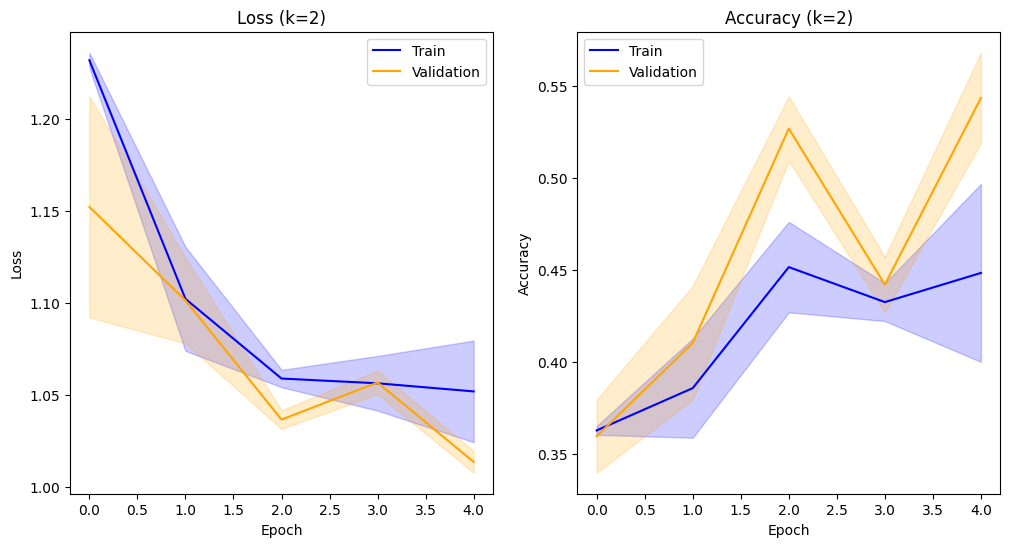

Précision : moyenne=54.365% écart-type=2.460%, k=2


In [18]:
k=2 # Nombre de folds
epochs=5 # Nombre d'epochs
shapeinput=(64, 64, 3) # Format de l'image 28x28 sur 1 canal
run_evaluation(k,epochs)

In [13]:
def train_cnn_model(model, train_ds, val_data, model_path,
                    epochs=10, patience=3, mult_datagen=1):
    """
    Entraîne un modèle CNN avec un générateur de données et des callbacks.

    Args:
        model: Modèle CNN à entraîner.
        train_generator: Générateur d’images pour l'entraînement.
        val_data: Données de validation (X_test, y_test).
        model_path (str): Chemin de sauvegarde du modèle.
        epochs (int): Nombre d’époques d'entraînement.
        patience (int): Patience pour l'arrêt anticipé.

    Returns:
        Modèle entraîné avec les meilleurs poids restaurés.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(model_path, monitor='val_loss',
                        save_best_only=True, verbose=1)
    ]
    base_steps = int(np.ceil(len(X_train) / batch_size))
    steps_per_epoch = mult_datagen * base_steps  # len = ceil(n_samples / batch_size)
    print(f"Image par epoch(avec datagen) : {steps_per_epoch * batch_size}, nb image par batch : {batch_size}")
    model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        callbacks=callbacks,
        verbose=1
    )

    return model

# Paramètres d'entraînement
epochs = 20
batch_size = 128
model_filename = "CNN_MC.keras"

# Définition du répertoire cible
model_dir = "./data/models"

# Création du répertoire s'il n'existe pas
os.makedirs(model_dir, exist_ok=True)


model_path = os.path.join(model_dir, model_filename)
# Chemin des images
data_dir = "./data/dataset/sheep_cat_elephant_with_caption_600/images"
# Chargement et normalisation du jeu de données
X_train, y_train, X_test, y_test, class_names = load_dataset()
X_train, X_test = clean_data(X_train, X_test)

# Définition du modèle
model = define_model()
print(model.summary())

AUTOTUNE = tf.data.AUTOTUNE

augment = tf.keras.Sequential(
    [
        tf.keras.layers.RandomTranslation(0.2, 0.2),
        tf.keras.layers.RandomFlip("horizontal"),
    ],
    name="augment",
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)
train_ds = train_ds.batch(batch_size, drop_remainder=False)
train_ds = train_ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat().prefetch(AUTOTUNE)  # <-- repeat()

# Nombre de batchs "normal" pour 1 epoch
base_steps = int(np.ceil(len(X_train) / batch_size))

# ICI tu décides "plus d'échantillons par epoch" (ex: 3x)
steps_per_epoch = 3 * base_steps

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_Layer (Conv2D)            │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1_Layer (MaxPooling2D)      │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_Layer (Conv2D)            │ (None, 123, 123, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2_Layer (MaxPooling2D)      │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_Layer (Conv2D)            │ (None, 57, 57, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3_Layer (MaxPooling2D)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1_Layer (Dense)            │ (None, 200)            │     5,017,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,070,563 (19.34 MB)

 Trainable params: 5,070,563 (19.34 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
model = train_cnn_model(model, train_ds,
                          (X_test, y_test), model_path, epochs=epochs, patience=6, mult_datagen=2)

Image par epoch(avec datagen) : 2560, nb image par batch : 128
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9742 - loss: 0.0648
Epoch 1: val_loss improved from None to 1.58236, saving model to ./data/models\CNN_MC.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 589ms/step - accuracy: 0.9738 - loss: 0.0714 - val_accuracy: 0.7370 - val_loss: 1.5824
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9779 - loss: 0.0598
Epoch 2: val_loss did not improve from 1.58236
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - accuracy: 0.9790 - loss: 0.0594 - val_accuracy: 0.7426 - val_loss: 1.7074
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9815 - loss: 0.0539
Epoch 3: val_loss did not improve from 1.58236
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 559ms/step - accuracy: 0.9810 - loss: 0.0545 - val_accuracy: 0.7204 - val_loss: 1.8772
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9844 - loss: 0.0569
Epoch 4: val_loss did not improve from 1.58236
20/20 

In [33]:
# Chargement du modèle sauvegardé
model_filename = "CNN_MC.keras"
model_path = os.path.join(model_dir, model_filename)
model = load_model(model_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


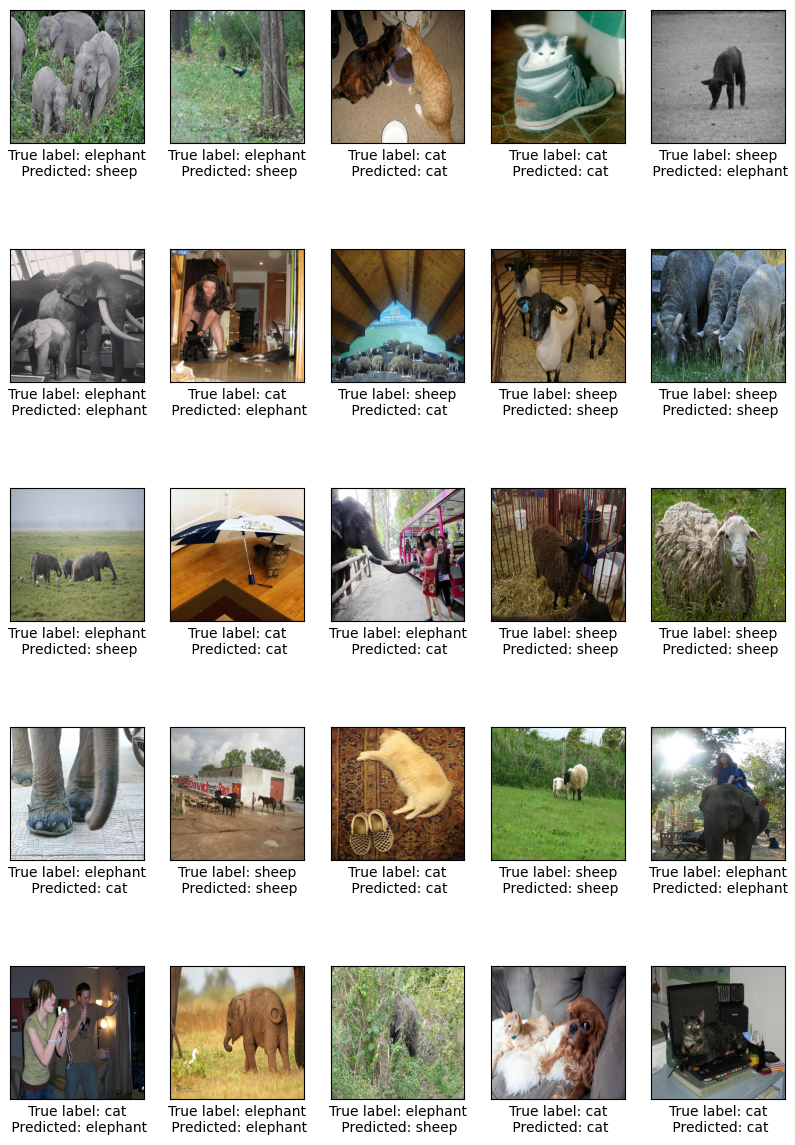

In [34]:


numimage = 110
# Prédiction
y_pred = model.predict(X_test[numimage:numimage+25])  # Prédire 25 image
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)
plt.figure(figsize=(10,15))
columns = 25
for i in range(columns):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i+numimage],cmap=plt.cm.binary)
    plt.xlabel("True label: " + class_names[y_true_labels[i+numimage]] + "\n Predicted: " + class_names[y_pred_labels[i]])

In [35]:
# Chargement du modèle sauvegardé
model_filename = "CNN_MC.keras"
model_path = os.path.join(model_dir, model_filename)
model = load_model(model_path)

# Prédiction
y_pred = model.predict(X_test)  # Prédire les 10 premières images d'entraînement
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)

# Matrice de confusion
conf = confusion_matrix(y_true_labels, y_pred_labels)



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


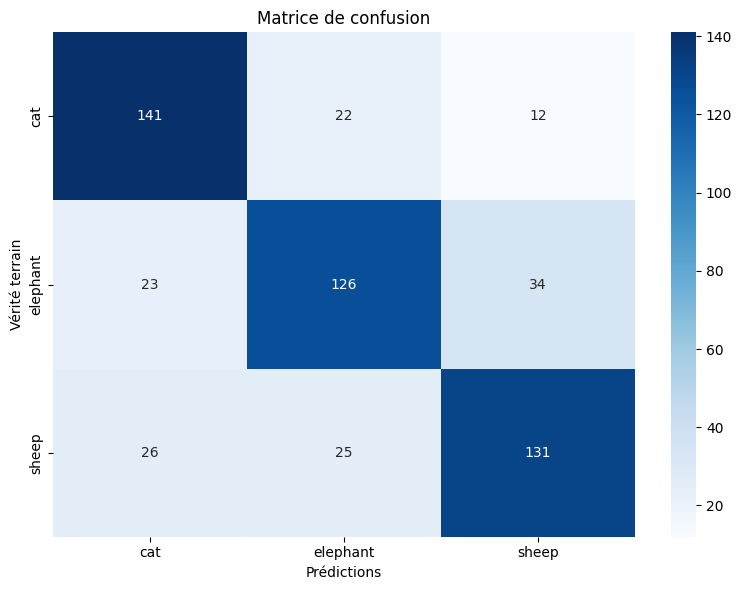

In [36]:
# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.tight_layout()
plt.show()